In [60]:
from src import *

### Export

In [61]:
def save_output(time, Rs_sol, ps_sol, N, Omega, custom_name = "name", skip = 10, num = 50000):
    if custom_name == "name":
        f = open(f"outputOmega{Omega}N{N}.txt", "w")
    else:
        f = open(f"{custom_name}.txt", "w")
    for i in range(0, num, skip):
        f.write("ITEM: TIMESTEP"+ '\n')
        f.write(str(time[i])+ '\n')
        f.write("ITEM: NUMBER OF ATOMS"+ '\n'), 
        f.write(str(N)+ '\n')
        f.write("ITEM: ATOMS id x y z vx vy vz"+ '\n')
        for j in range(N):
            s = ''
            s += str(j)
            for k in range(3):
                s += ' '
                s += str(Rs_sol[i, j, k])
            #s += ' 0'
            for k in range(3):
                s += ' '
                s += str(ps_sol[i, j, k])
            f.write(s+ '\n')
    f.close()        
    

### Plotting

In [62]:
def plot_function(coordinates, values, grid_size=100, custom_name = "Average value"):
    """
    Plot the average function value over the coordinates on a 2D plot.

    Parameters:
        coordinates (list of tuples): List of (x, y) coordinates.
        values (list of floats): Function values corresponding to each coordinate.
        grid_size (int): Number of grid points in each dimension for averaging.
    """
    # Convert input to numpy arrays
    coordinates = np.array(coordinates)
    values = np.array(values)

    # Create a grid for averaging
    x_min, x_max = coordinates[:, 0].min(), coordinates[:, 0].max()
    y_min, y_max = coordinates[:, 1].min(), coordinates[:, 1].max()
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    xx, yy = np.meshgrid(x_grid, y_grid)

    # Initialize grid for averaged values
    avg_values = np.zeros_like(xx)
    count = np.zeros_like(xx)

    # Compute the average values for each grid cell
    for (x, y), value in zip(coordinates, values):
        i = np.searchsorted(x_grid, x) - 1
        j = np.searchsorted(y_grid, y) - 1

        if 0 <= i < grid_size - 1 and 0 <= j < grid_size - 1:
            avg_values[j, i] += value
            count[j, i] += 1

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        avg_values = np.divide(avg_values, count, out=np.zeros_like(avg_values), where=count > 0)

    # Plot the results
    plt.figure(figsize=(8, 6))
    #plt.contourf(xx, yy, avg_values, levels=50, cmap='jet')
    plt.pcolormesh(xx, yy, avg_values, cmap='viridis')
    plt.colorbar(label=custom_name)
    #plt.scatter(coordinates[:, 0], coordinates[:, 1], c=values, edgecolor='k', cmap='viridis', label="Data Points")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(custom_name)
    #plt.legend()
    angle = np.linspace(-np.pi, np.pi, 100)
    plt.plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
    plt.plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
    plt.axis('equal')
    plt.show()


In [63]:
def plot_density(R, Omegas):
    fig, axs = plt.subplots(2, 5, figsize = (15,6))
    for i in range(len(Omegas)):
        steady = R[i][-40000:-1:100, :, :]
        coords = steady.reshape((40000,3))
        psi = np.arctan2(coords[:, 1], coords[:, 0])
        r = np.linalg.norm(coords[:, :2], axis = 1)
        axs[i // 5, i % 5].hist2d(coords[:, 0], coords[:, 1], bins = 40, range = [[-R2, R2], [-R2, R2]])
        axs[i // 5, i % 5].axis('equal')
        axs[i // 5, i % 5].set_xlabel('x')
        axs[i // 5, i % 5].set_ylabel('y')
        axs[i // 5, i % 5].set_title(f'{Omegas[i]:.2f}')
        angle = np.linspace(-np.pi, np.pi, 100)
        axs[i // 5, i % 5].plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
        axs[i // 5, i % 5].plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
        approx_R = get_params(Omegas[i])[1] / v0
        #axs[i // 5, i % 5].plot(approx_R * np.cos(angle), approx_R * np.sin(angle), color = 'red')
    fig.suptitle('density')
    plt.show()

In [64]:
def plot_velocity(R, Omegas, dt = 0.1, grid_size=50):
    
    fig1, axs1 = plt.subplots(2, 5, figsize = (17,7))
    fig2, axs2 = plt.subplots(2, 5, figsize = (17,7))
    for l in range(len(Omegas)):
        steady = R[l][-40000:-1:100, :, :]
        coords = steady.reshape((40000,3))
        coords = coords[:,:2]
        steady1 = R[l][-40001:-2:100, :, :]
        vs = (steady - steady1) / dt
        vs = vs.reshape((40000,3))
        psi = np.arctan2(coords[:, 1], coords[:, 0])
        alpha = np.arctan2(vs[:, 1], vs[:, 0])
        r = np.linalg.norm(coords[:, :2], axis = 1)
        v = np.linalg.norm(vs[:, :2], axis = 1)
        v_r = v * np.cos(psi - alpha)
        v_phi = v * np.sin(psi - alpha)
        

        # Create a grid for averaging
        x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
        y_min, y_max = coords[:, 1].min(), coords[:, 1].max()
        x_grid = np.linspace(x_min, x_max, grid_size)
        y_grid = np.linspace(y_min, y_max, grid_size)
        xx, yy = np.meshgrid(x_grid, y_grid)

        # Initialize grid for averaged values of v_phi
        avg_v_phi = np.zeros_like(xx)
        count = np.zeros_like(xx)

        # Compute the average values for each grid cell
        for (x, y), value in zip(coords, v_phi):
            i = np.searchsorted(x_grid, x) - 1
            j = np.searchsorted(y_grid, y) - 1

            if 0 <= i < grid_size - 1 and 0 <= j < grid_size - 1:
                avg_v_phi[j, i] += value
                count[j, i] += 1

        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            avg_v_phi = np.divide(avg_v_phi, count, out=np.zeros_like(avg_v_phi), where=count > 0)

        # Initialize grid for averaged values of v_r
        avg_v_r = np.zeros_like(xx)
        count = np.zeros_like(xx)

        # Compute the average values for each grid cell
        for (x, y), value in zip(coords, v_r):
            i = np.searchsorted(x_grid, x) - 1
            j = np.searchsorted(y_grid, y) - 1

            if 0 <= i < grid_size - 1 and 0 <= j < grid_size - 1:
                avg_v_r[j, i] += value
                count[j, i] += 1

        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            avg_v_r = np.divide(avg_v_r, count, out=np.zeros_like(avg_v_r), where=count > 0)

        # Plot the results
        pcm = axs1[l // 5, l % 5].pcolormesh(xx, yy, avg_v_phi, cmap='viridis')
        fig1.colorbar(pcm, ax =  axs1[l // 5, l % 5])
        axs1[l // 5, l % 5].set_xlabel("x")
        axs1[l // 5, l % 5].set_ylabel("y")
        axs1[l // 5, l % 5].set_title(f'{Omegas[l]:.2f}')
        angle = np.linspace(-np.pi, np.pi, 100)
        axs1[l // 5, l % 5].plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
        axs1[l // 5, l % 5].plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
        axs1[l // 5, l % 5].axis('equal')

        pcm = axs2[l // 5, l % 5].pcolormesh(xx, yy, avg_v_r, cmap='viridis')
        fig2.colorbar(pcm, ax =  axs2[l // 5, l % 5])
        axs2[l // 5, l % 5].set_xlabel("x")
        axs2[l // 5, l % 5].set_ylabel("y")
        axs2[l // 5, l % 5].set_title(f'{Omegas[l]:.2f}')
        angle = np.linspace(-np.pi, np.pi, 100)
        axs2[l // 5, l % 5].plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
        axs2[l // 5, l % 5].plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
        axs2[l // 5, l % 5].axis('equal')
  
    fig1.suptitle('v_phi')
    fig2.suptitle('v_r')
    plt.show()


In [65]:
def plot_delta(R, p, Omegas):
    deltas = []
    for i in range(len(Omegas)):
        steady = R[i][-40000:-1:100, :, :]
        coords = steady.reshape((40000,3))
        psi = np.arctan2(coords[:, 1], coords[:, 0])
        steady_p = p[i][-40000:-1:100, :, :]
        coords_p = steady_p.reshape((40000,3))
        phi = np.arctan2(coords_p[:, 1], coords_p[:, 0])
        delta = psi - phi
        deltas.append(np.mean(delta))
    plt.plot(Omegas, deltas)
    plt.xlabel("Omega")
    plt.ylabel("delta")
    plt.show()

### Test run

In [66]:
N = 100
zs = np.random.uniform(0, L, N)
psis = np.random.uniform(0, 2*np.pi, N)
Rs = np.random.triangular(R1 + R, R2 - R, R2 - R, N)
vecs = np.random.normal(size = (N, 3))
R0s = []
p0s = []
kx = np.array([1, 0, 0]) # up vector
k0 = np.array([0, 0, 0]) 
for i in range(N):
    R0s.append([Rs[i] * np.cos(psis[i]), Rs[i] * np.sin(psis[i]), zs[i]])
    p0s.append(vecs[i]/np.linalg.norm(vecs[i]))

In [67]:
ps_sol, Rs_sol, t = solver(0.1, 0.01, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

No tumbling
omega/D_R: 30.660153746057613


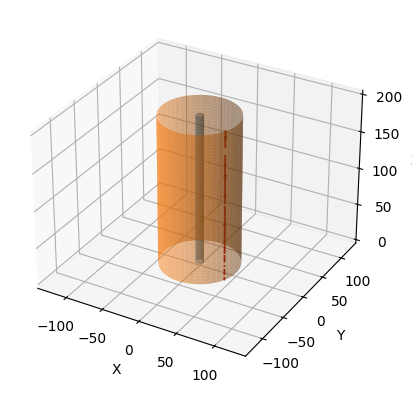

In [68]:
plot_state(Rs_sol[-1, :, :])

In [69]:
pss, Rss, t = solver(5, 0.01, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806


In [70]:
save_output(t, Rss, pss, N, 5)

In [71]:
steady = Rss[-40000:-1:100, :, :]
coords = steady.reshape((40000,3))
psi = np.arctan2(coords[:, 1], coords[:, 0])
r = np.linalg.norm(coords[:, :2], axis = 1)

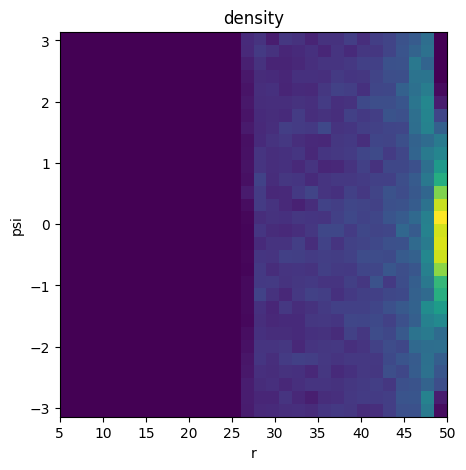

In [72]:
fig, axs = plt.subplots(figsize = (5,5))
axs.hist2d(r, psi, bins = 30, range = [[R1, R2], [-np.pi, np.pi]])
axs.set_xlabel('r')
axs.set_ylabel('psi')
axs.set_title('density')
plt.show()

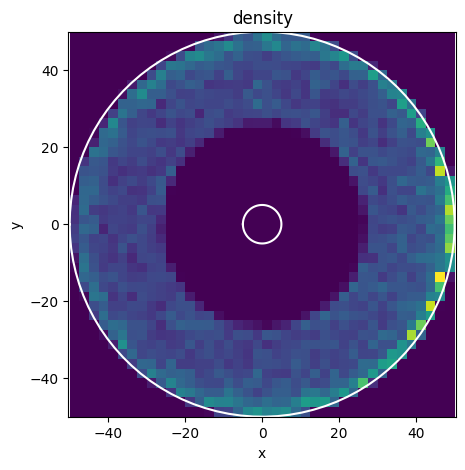

In [73]:
fig, axs = plt.subplots(figsize = (5,5))
axs.hist2d(coords[:, 0], coords[:, 1], bins = 40, range = [[-R2, R2], [-R2, R2]])
axs.axis('equal')
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title('density')
angle = np.linspace(-np.pi, np.pi, 100)
axs.plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
axs.plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
#plt.colorbar()
plt.show()

In [74]:
steady = Rss[-40000:-1:100, :, :]
coords = steady.reshape((40000,3))
#coords = Rss[-1, :, :]
#vs = (Rss[-1, :, :] - Rss[-2, :, :]) / 0.1
steady1 = Rss[-40001:-2:100, :, :]
vs = (steady - steady1) / 0.1
vs = vs.reshape((40000,3))
psi = np.arctan2(coords[:, 1], coords[:, 0])
alpha = np.arctan2(vs[:, 1], vs[:, 0])
r = np.linalg.norm(coords[:, :2], axis = 1)
v = np.linalg.norm(vs[:, :2], axis = 1)
v_r = v * np.cos(psi - alpha)
v_phi = v * np.sin(psi - alpha)

In [75]:
steady_p = pss[-40000:-1:100, :, :]
coords_p = steady.reshape((40000,3))
phi = np.arctan2(coords_p[:, 1], coords_p[:, 0])
delta = psi-phi

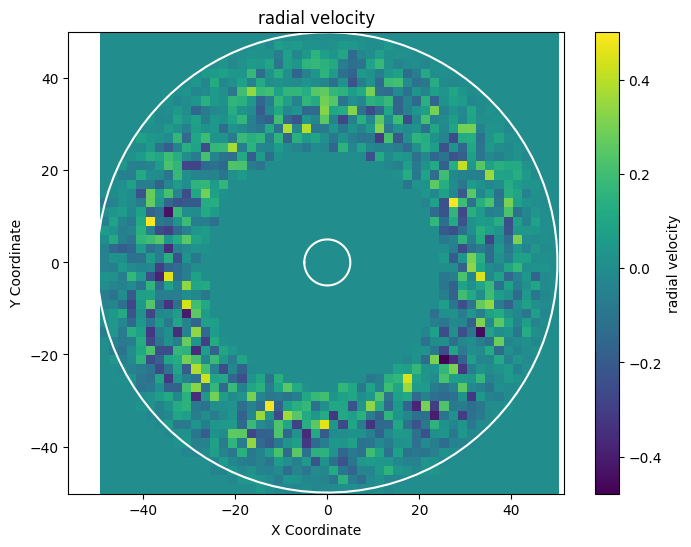

In [76]:
plot_function(coords[:,:2], v_r, grid_size = 50, custom_name = "radial velocity")

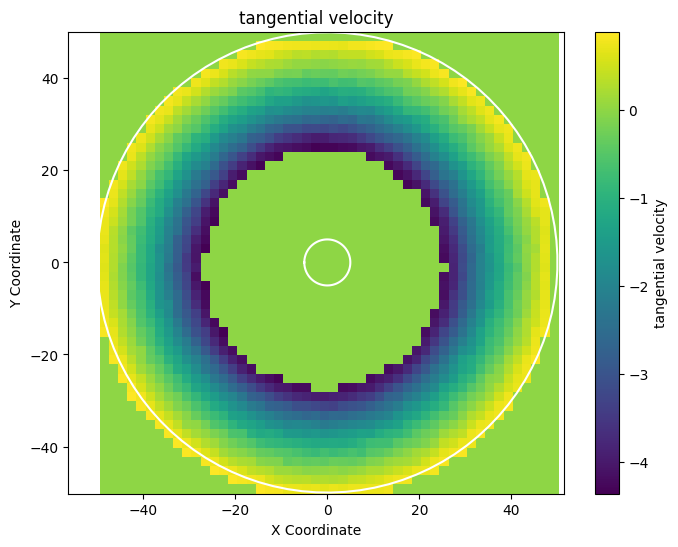

In [77]:
plot_function(coords[:,:2], v_phi, grid_size = 50, custom_name = "tangential velocity")

In [78]:
ps1, Rs1, t = solver(0.5, 0.01, k0, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

Tumbling period: 1431.7881813614306
omega/D_R: 153.30076873028807


In [79]:


steady1 = Rs1[-40000:-1:100, :, :]
coords1 = steady1.reshape((40000,3))
psi = np.arctan2(coords1[:, 1], coords1[:, 0])
steady_p = ps1[-40000:-1:100, :, :]
coords_p = steady_p.reshape((40000,3))
phi = np.arctan2(coords_p[:, 1], coords_p[:, 0])
delta = (psi-phi)%(2*np.pi)


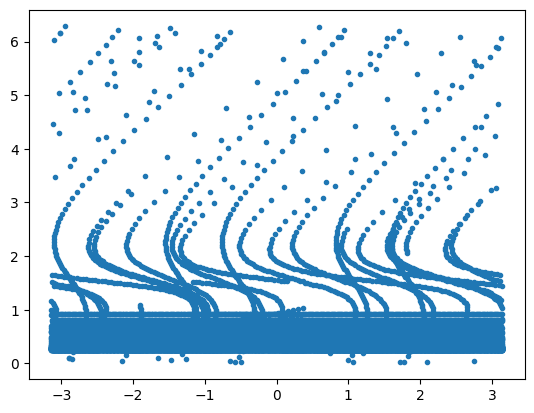

In [80]:
plt.plot(psi, delta, '.')

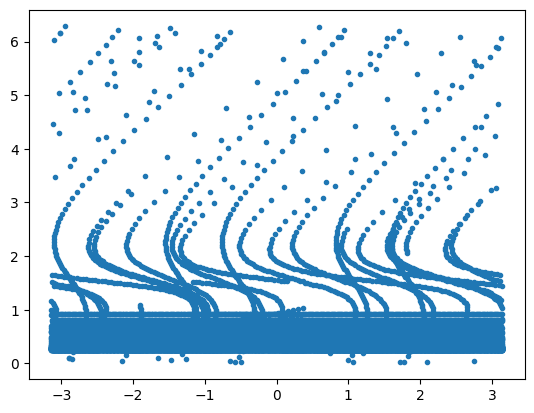

In [81]:
plt.plot(psi, delta, '.')

In [82]:
ps2, Rs2, t = solver(0.2, 0, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

No tumbling
omega/D_R: 61.32030749211523


In [83]:
save_output(t, Rs2, ps2, N, 0.2, custom_name = "Omega0.2")

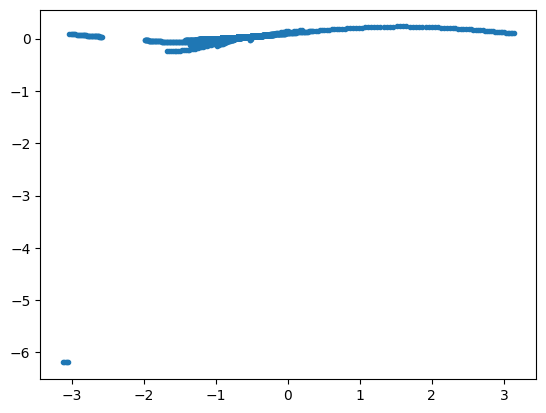

In [84]:

steady2 = Rs2[-40000:-1:100, :, :]
coords2 = steady2.reshape((40000,3))
psi2 = np.arctan2(coords2[:, 1], coords2[:, 0])
steady_p2 = ps2[-40000:-1:100, :, :]
coords_p2 = steady_p2.reshape((40000,3))
phi2 = np.arctan2(coords_p2[:, 1], coords_p2[:, 0])
delta2 = (psi2-phi2)
plt.plot(psi2, delta2, '.')

### Test run high epsilon

In [85]:
pss_e, Rss_e, t = solver(3, 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = False)

Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284


In [86]:
save_output(t, Rss_e, pss_e, N, 5, custom_name="epsilon10", skip = 100, num = 100000)

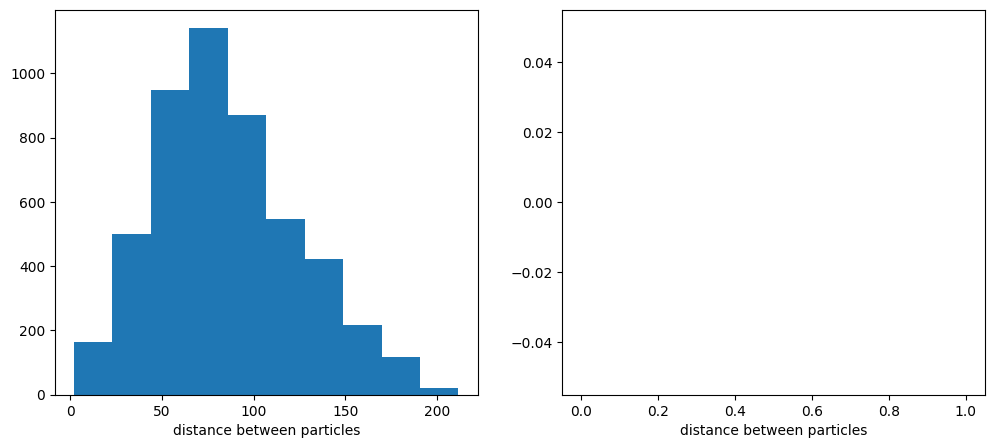

In [87]:
plot_dist(Rss_e, N, 2, 10)

In [131]:
from scipy.cluster.hierarchy import fclusterdata
clust = np.sort(fclusterdata(Rss_e[-1, :, :], t=3, criterion='distance'))
num = clust[-1]
print(clust)

[ 1  1  1  2  2  3  4  4  5  6  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 19 20 21 22 23 24 25 26 27 27 27 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 40 41 42 43 44 45 45 45 46 47 48 48 49 50 51 52 52 53 54 55 56 57 58
 59 60 61 62 63 63 64 65 66 67 68 69 70 70 71 71 72 73 74 74 75 76 77 78
 79 80 81 82]


In [119]:
clust_num = 0
for i in range(0, 100, 10):
    clust = np.sort(fclusterdata(Rss_e[-1 - i, :, :], t=3, criterion='distance'))
    clust_num += clust[-1]
clust_num = clust_num // 10
print(clust_num)

82


In [129]:
from collections import Counter 
 
def max_repetitions(sequence): 
    # Count the occurrences of each element 
    counts = Counter(sequence) 
    # Get the maximum count 
    max_count = max(counts.values()) 
    return max_count 
 
# Example usage 
sequence = [1, 2, 2, 3, 3, 3, 4, 4, 4, 4] 
result = max_repetitions(sequence) 
print(f"The maximum number of repetitions is: {result}") 

The maximum number of repetitions is: 4


In [132]:
max_repetitions(clust) 

4

# Scan

## Without gravity

In [90]:
Omegas = np.linspace(0., 1., 10)
R = []
p = []
for i in range(len(Omegas)):
    print(i)
    ps, Rs, t = solver(Omegas[i], 0.01, k0, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)
    

0
No tumbling
omega/D_R: 0.0
1
No tumbling
omega/D_R: 34.066837495619566
2
No tumbling
omega/D_R: 68.13367499123913
3
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
4
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
5
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
6
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
7
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
8
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
9
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


No tumbling
omega/D_R: 0.0
No tumbling
omega/D_R: 34.066837495619566
No tumbling
omega/D_R: 68.13367499123913
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


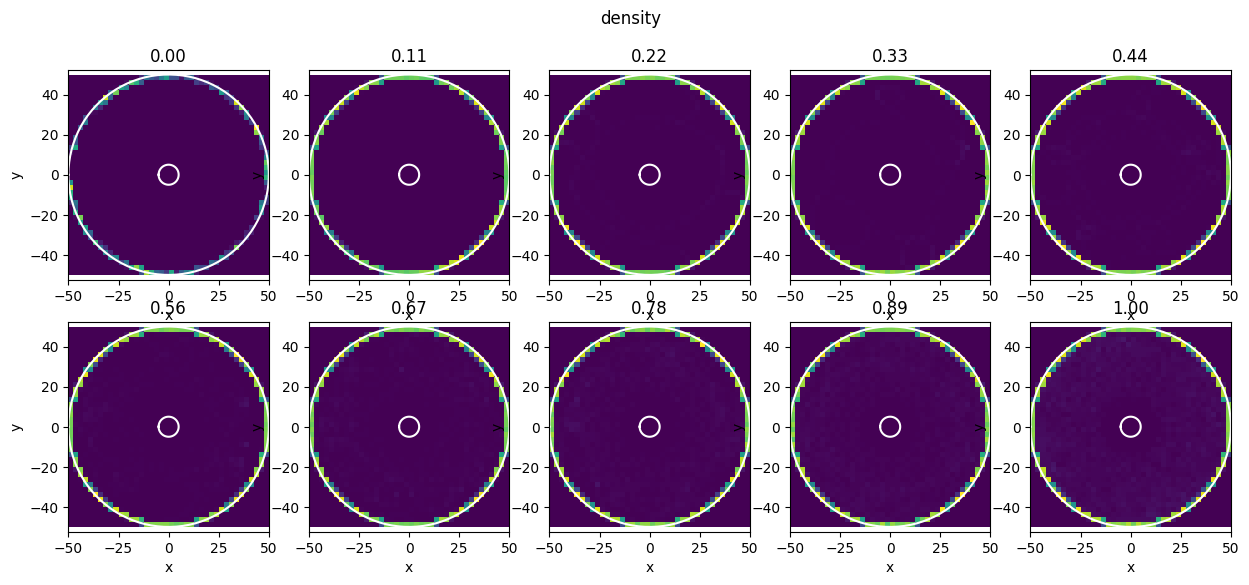

In [91]:
plot_density(R, Omegas)

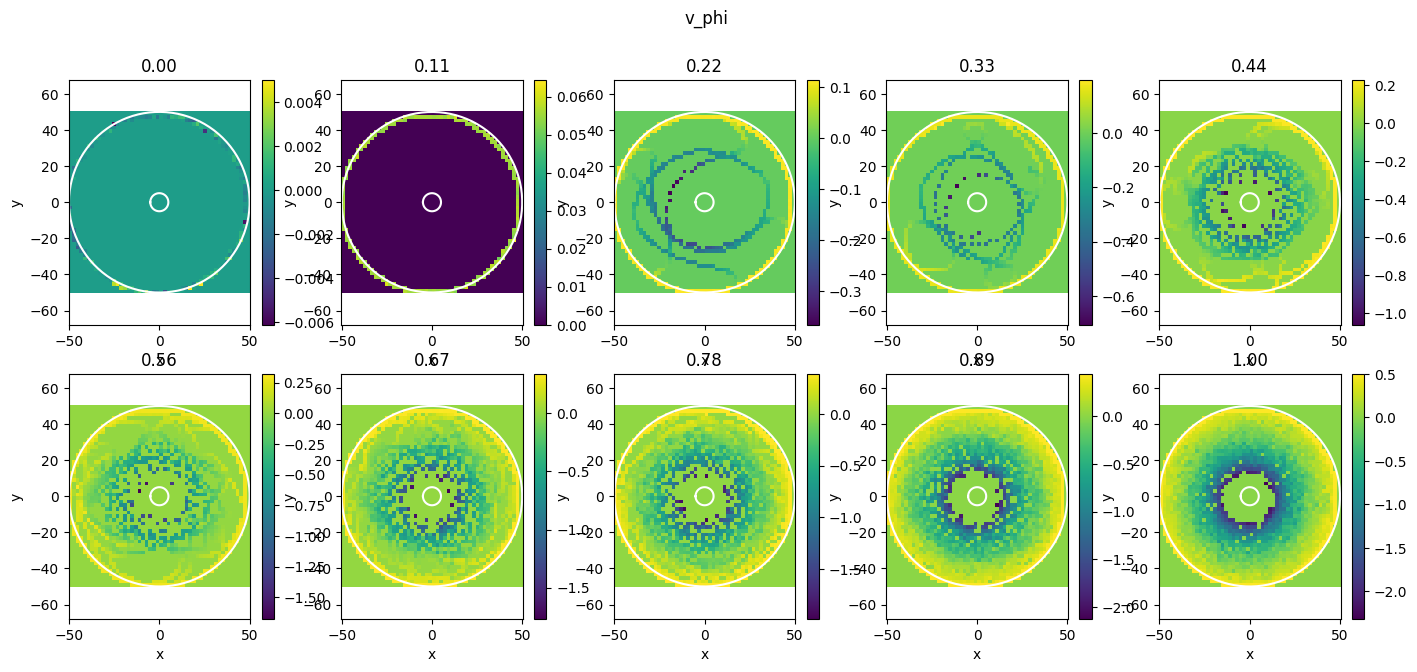

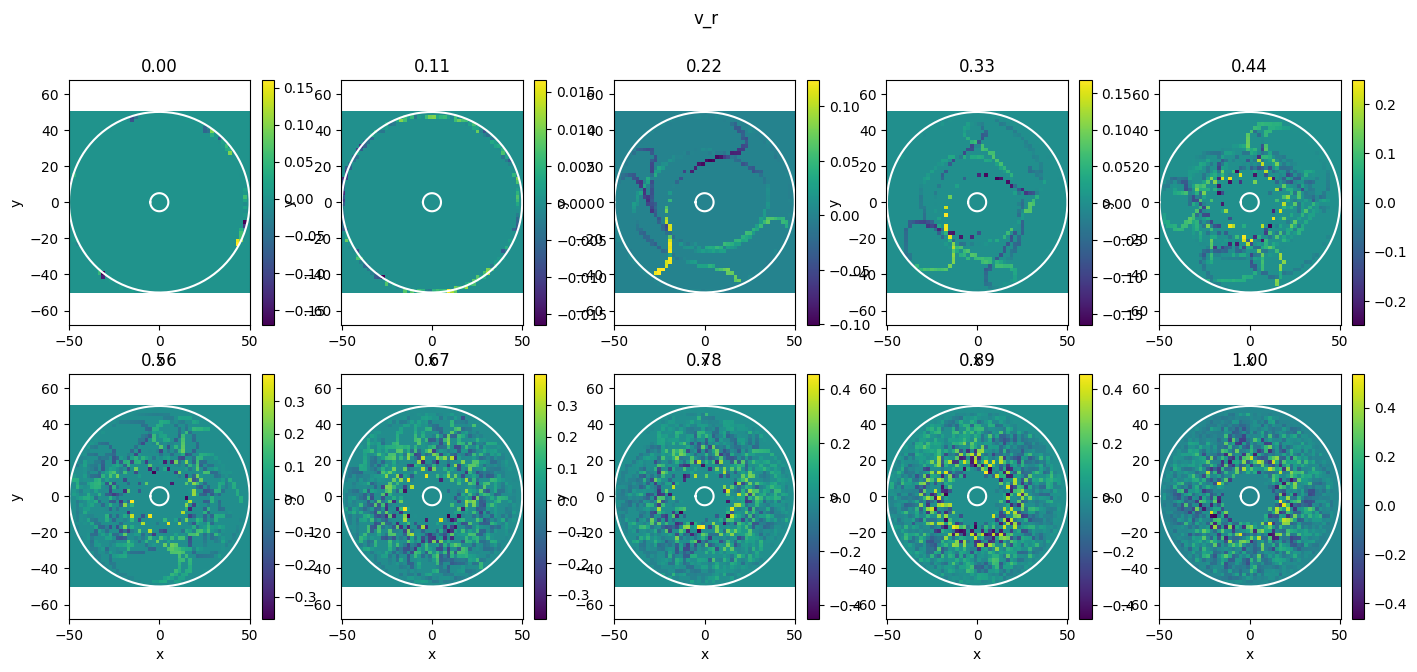

In [92]:
plot_velocity(R, Omegas)

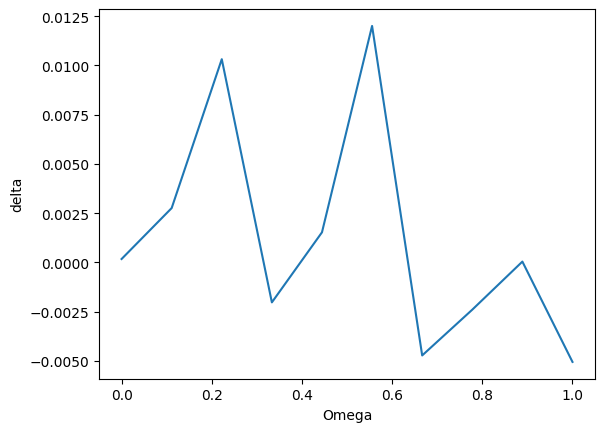

In [93]:
plot_delta(R, p, Omegas)

In [34]:
Omegas1 = np.linspace(1., 10., 10)
R.clear()
p.clear()
for i in range(len(Omegas1)):
    print(i)
    ps, Rs, t = solver(Omegas1[i], 0.01, k0, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)
    

0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
4
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
5
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
6
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
7
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
8
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
9
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


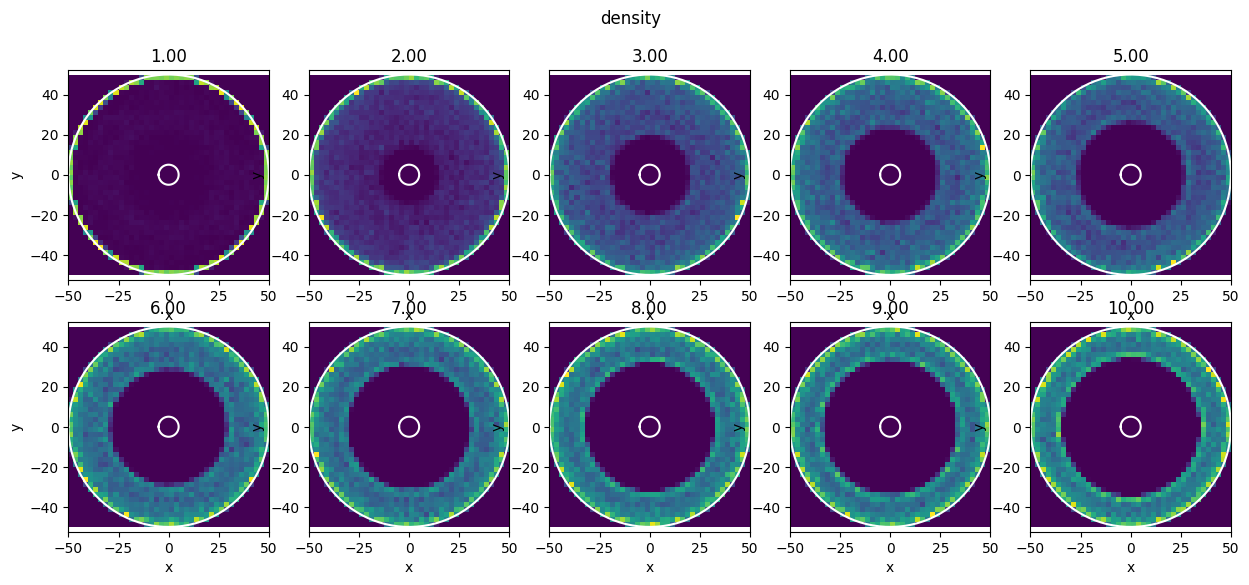

In [38]:
plot_density(R, Omegas1)

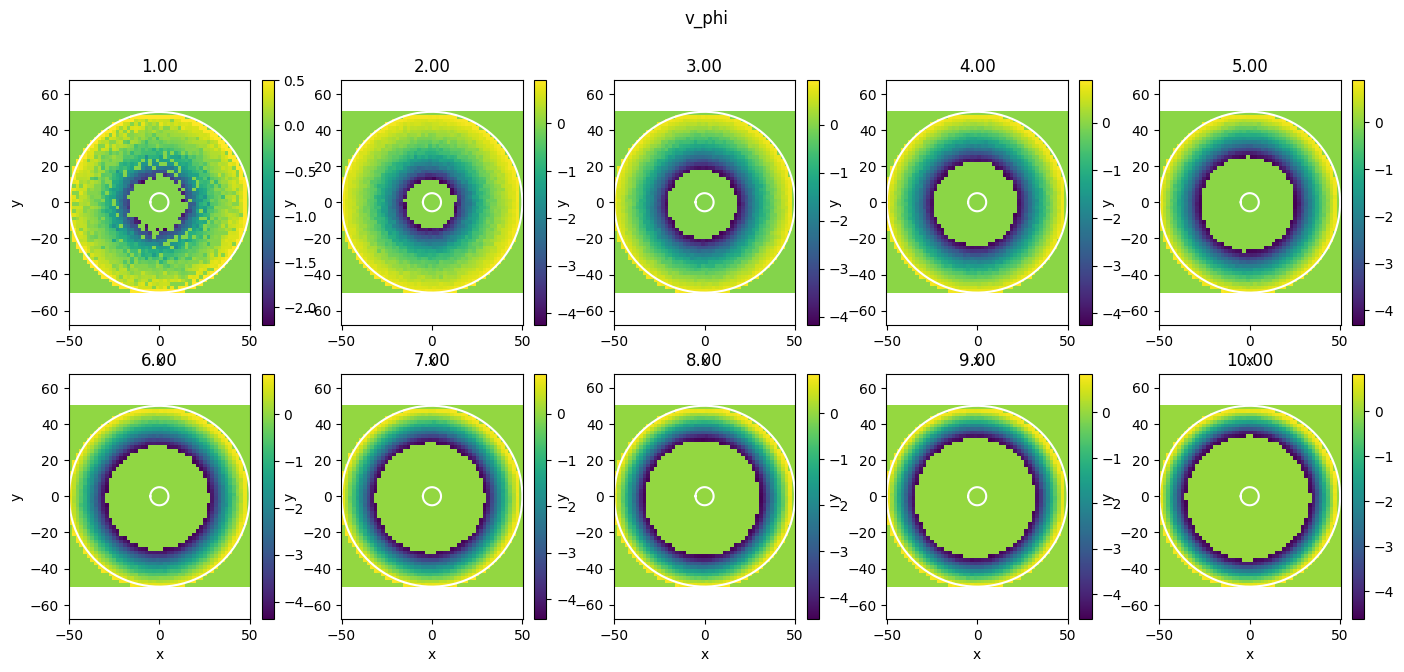

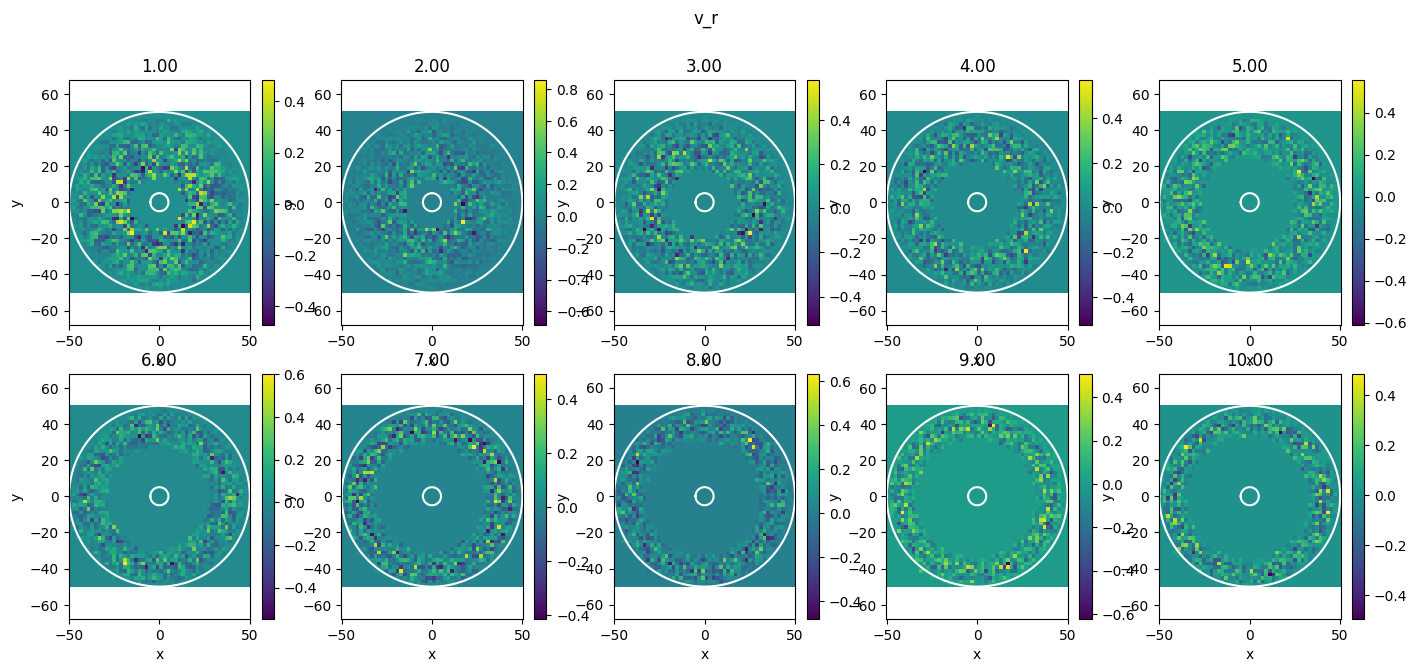

In [18]:
plot_velocity(R, Omegas1)

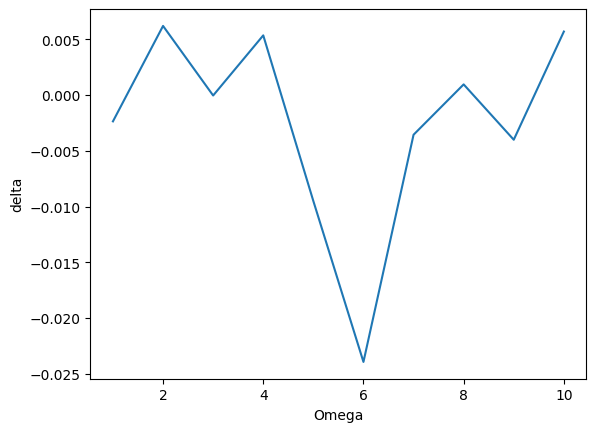

In [19]:
plot_delta(R, p, Omegas1)

## With gravity

In [121]:
R.clear()
p.clear()
for i in range(len(Omegas)):
    print(i)
    ps, Rs, t = solver(Omegas[i], 0.01, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)
    

0
No tumbling
omega/D_R: 0.0
1
No tumbling
omega/D_R: 34.066837495619566
2
No tumbling
omega/D_R: 68.13367499123913
3
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
4
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
5
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
6
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
7
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
8
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
9
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


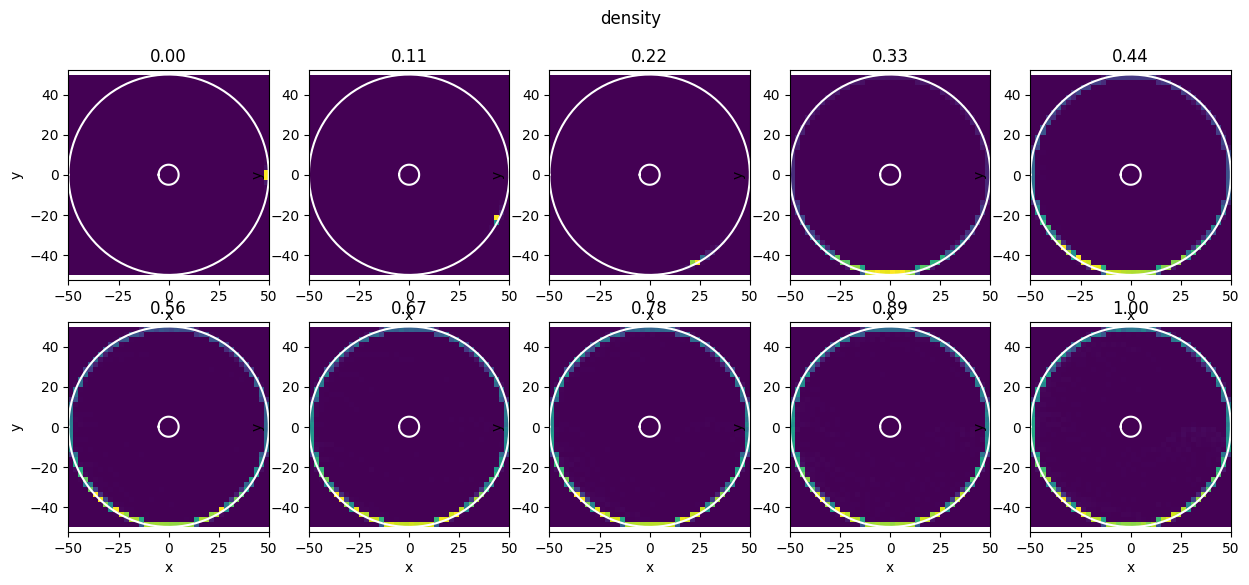

In [122]:
plot_density(R, Omegas)

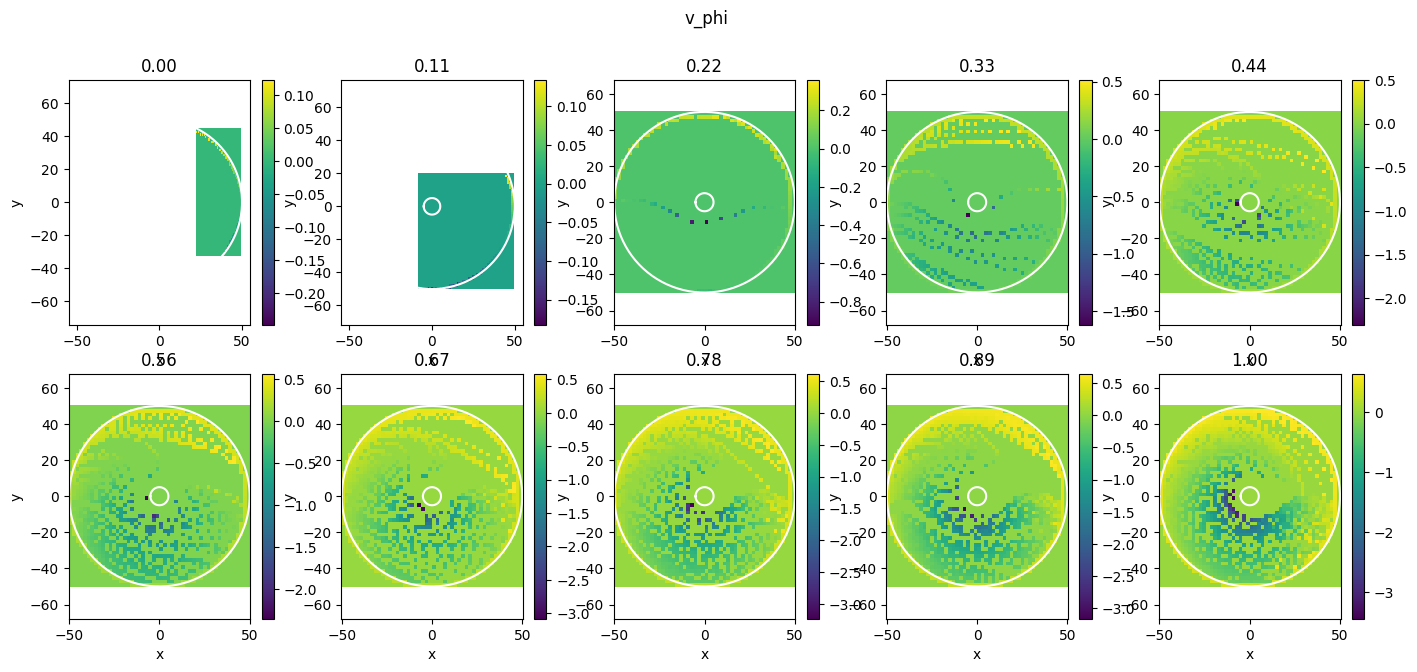

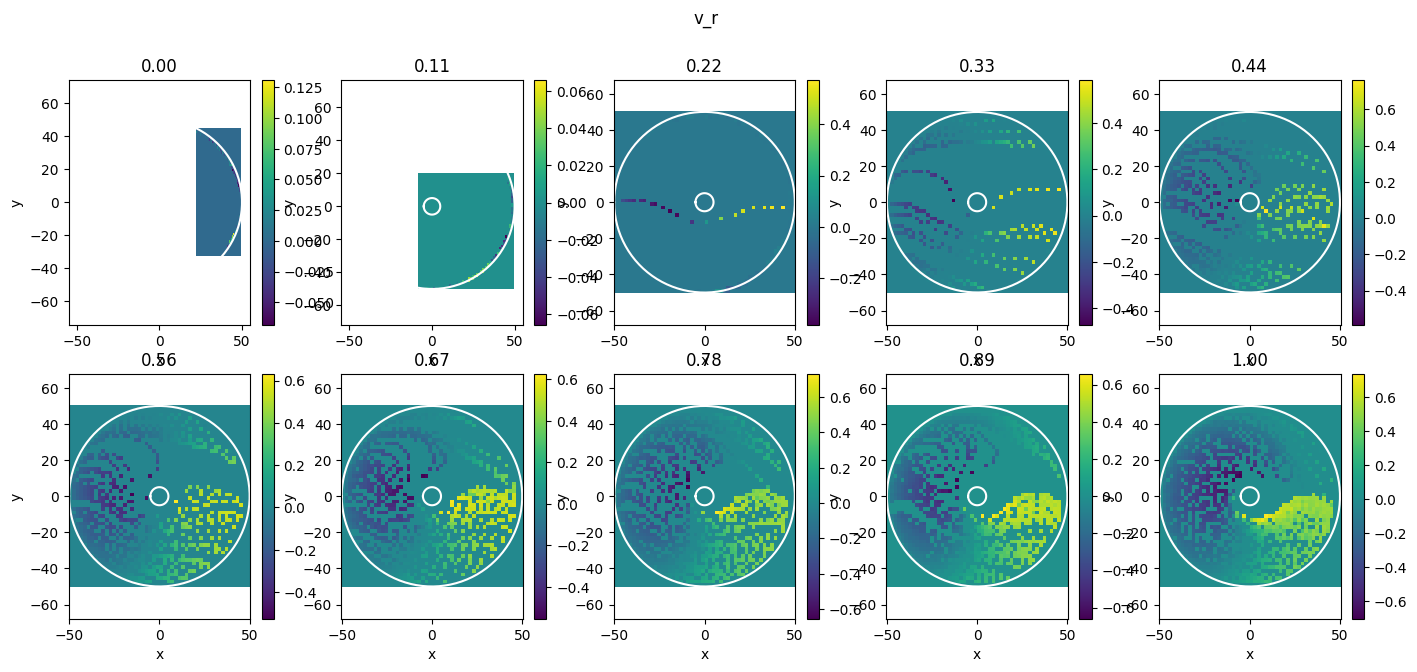

In [123]:
plot_velocity(R, Omegas)

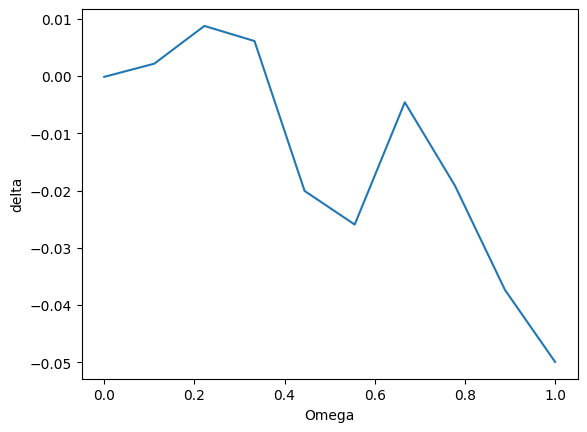

In [124]:
plot_delta(R, p, Omegas)

In [125]:
R.clear()
p.clear()
for i in range(len(Omegas1)):
    print(i)
    ps, Rs, t = solver(Omegas1[i], 0.01, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
4
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
5
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
6
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
7
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
8
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
9
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


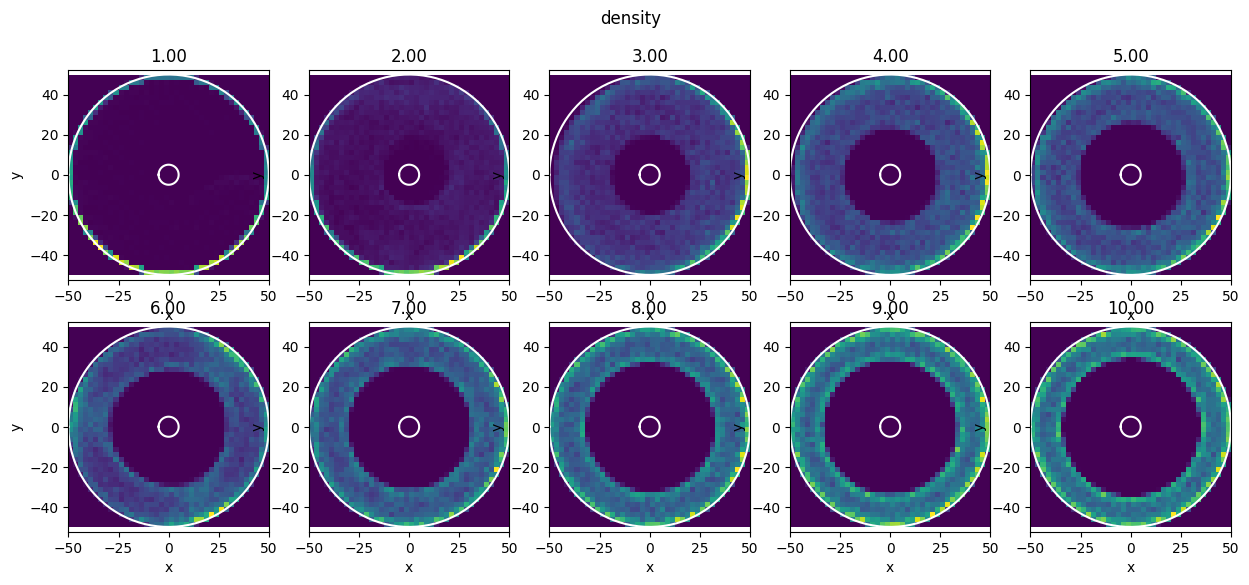

In [126]:
plot_density(R, Omegas1)

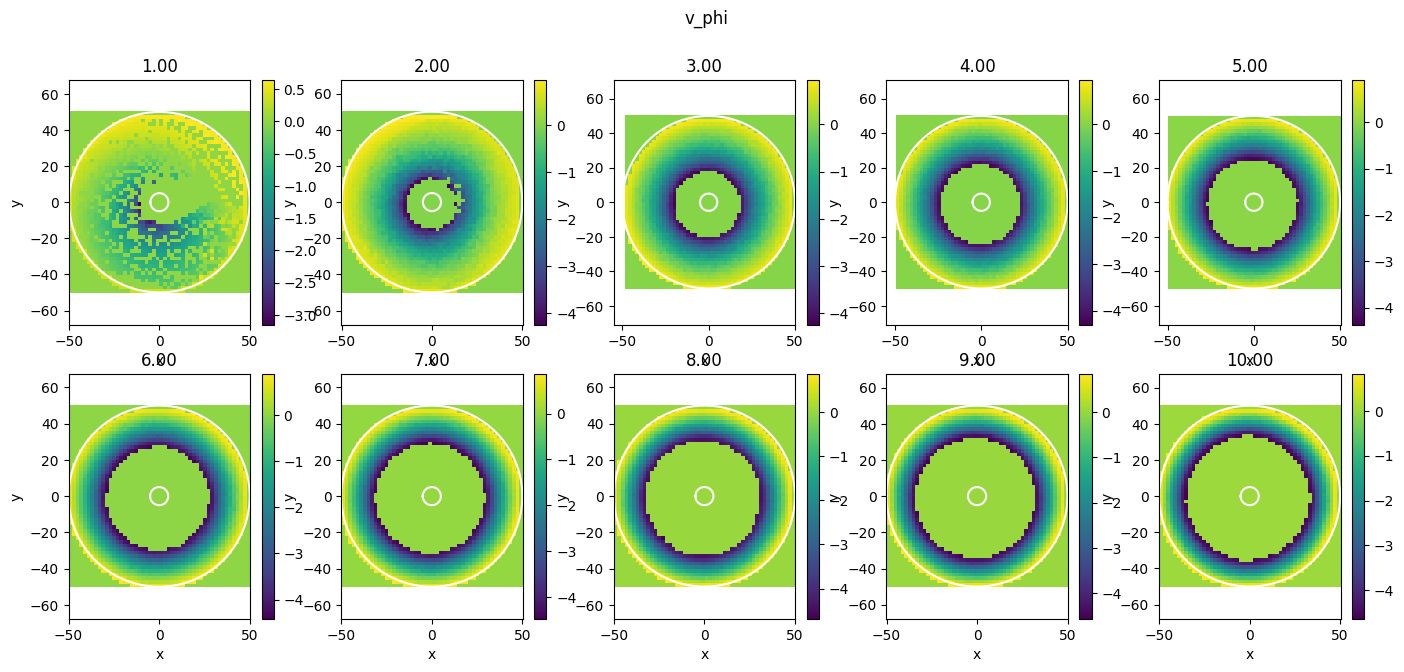

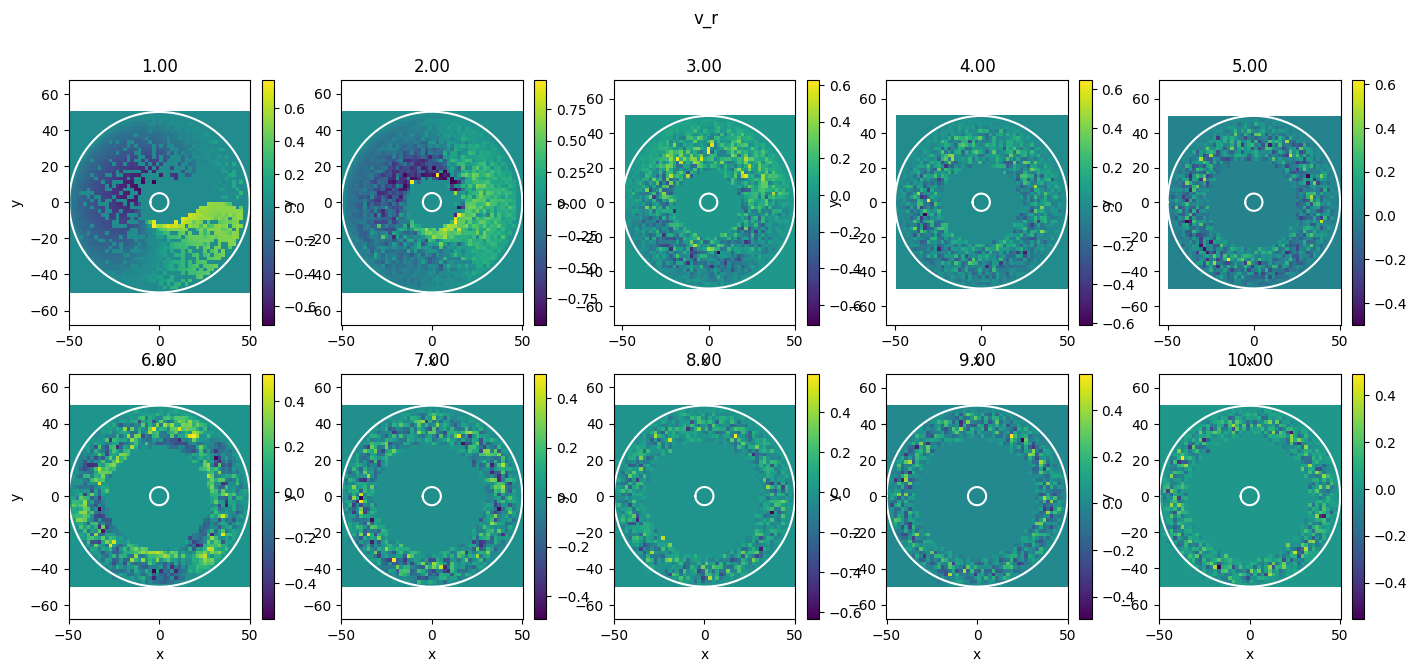

In [127]:
plot_velocity(R, Omegas1)

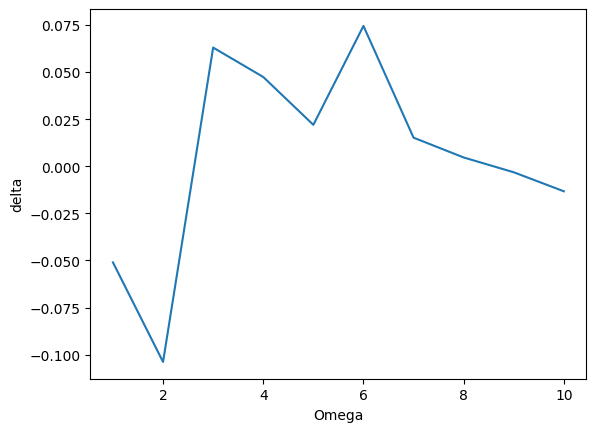

In [128]:
plot_delta(R, p, Omegas1)

## Without interaction

In [73]:
R.clear()
p.clear()
for i in range(len(Omegas)):
    print(i)
    ps, Rs, t = solver(Omegas[i], 0, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

0
No tumbling
omega/D_R: 0.0
1
No tumbling
omega/D_R: 34.066837495619566
2
No tumbling
omega/D_R: 68.13367499123913
3
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
4
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
5
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
6
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
7
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
8
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
9
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


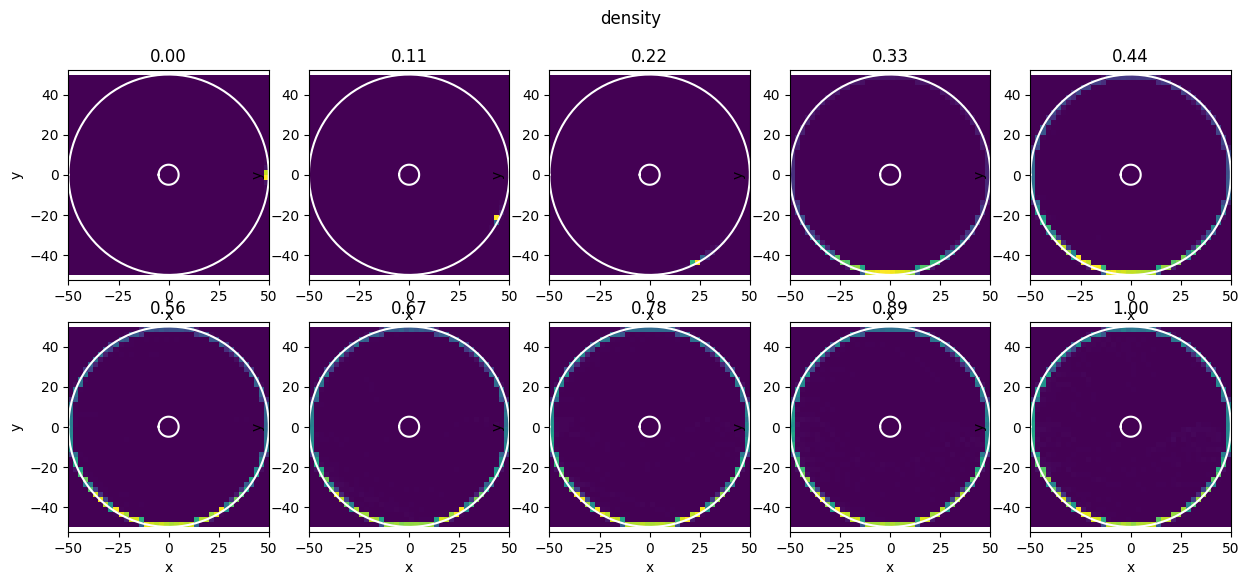

In [74]:
plot_density(R, Omegas)

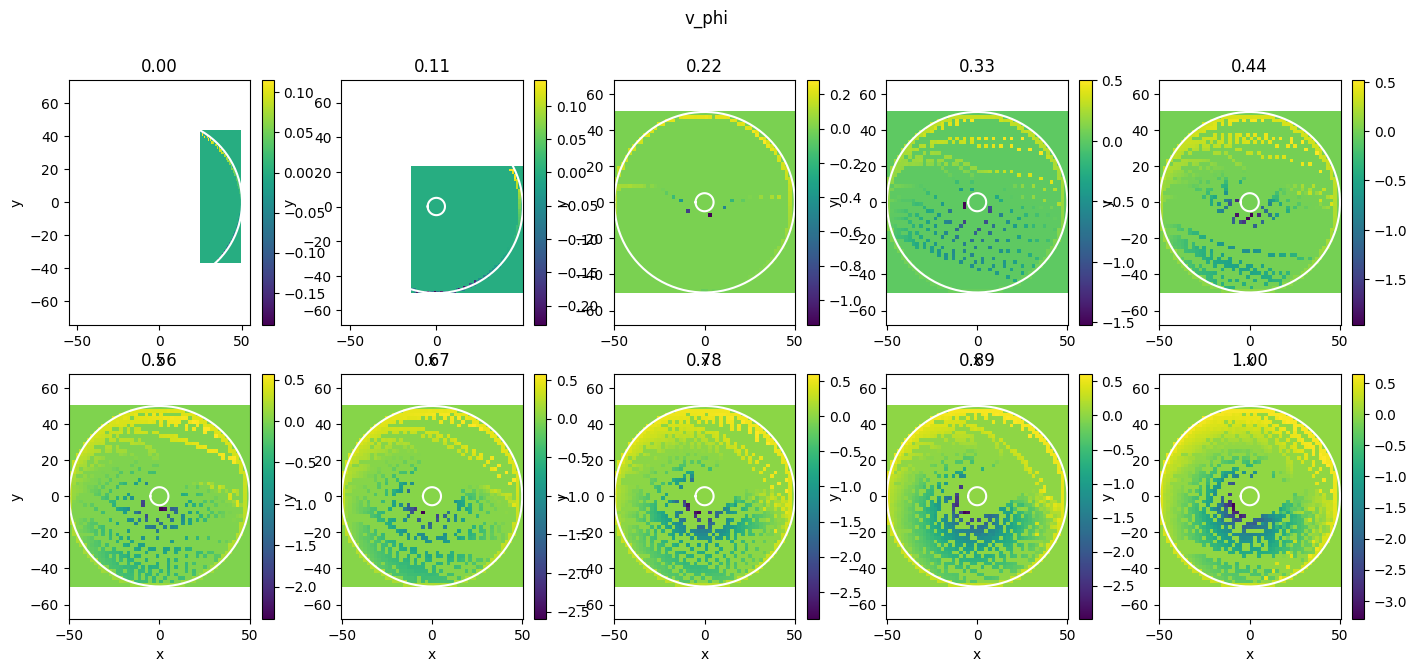

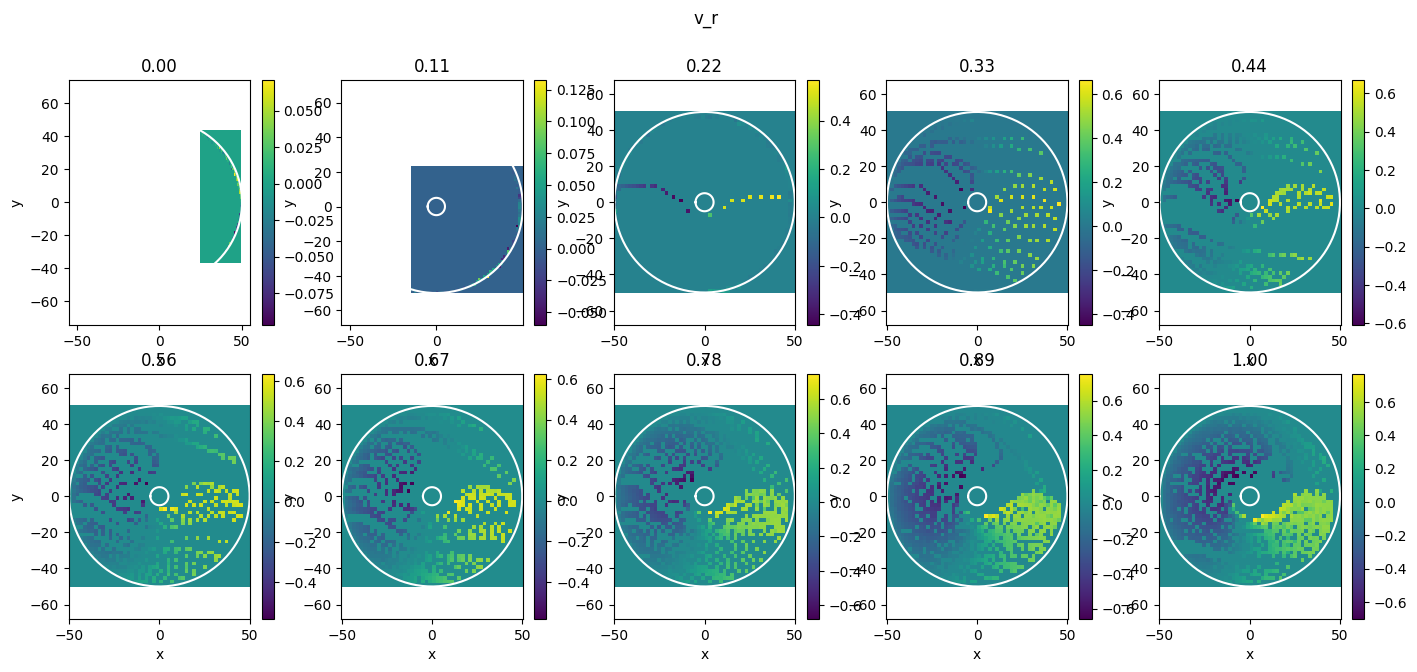

In [75]:
plot_velocity(R, Omegas)

In [76]:
R.clear()
p.clear()
for i in range(len(Omegas1)):
    print(i)
    ps, Rs, t = solver(Omegas1[i], 0, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
4
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
5
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
6
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
7
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
8
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
9
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


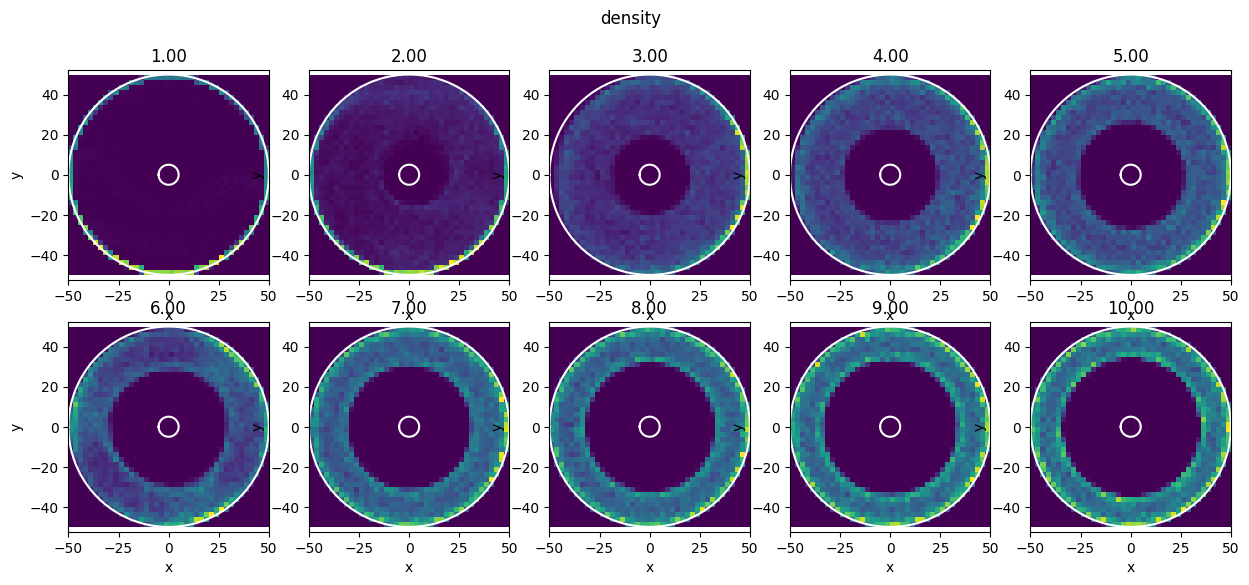

In [77]:
plot_density(R, Omegas1)

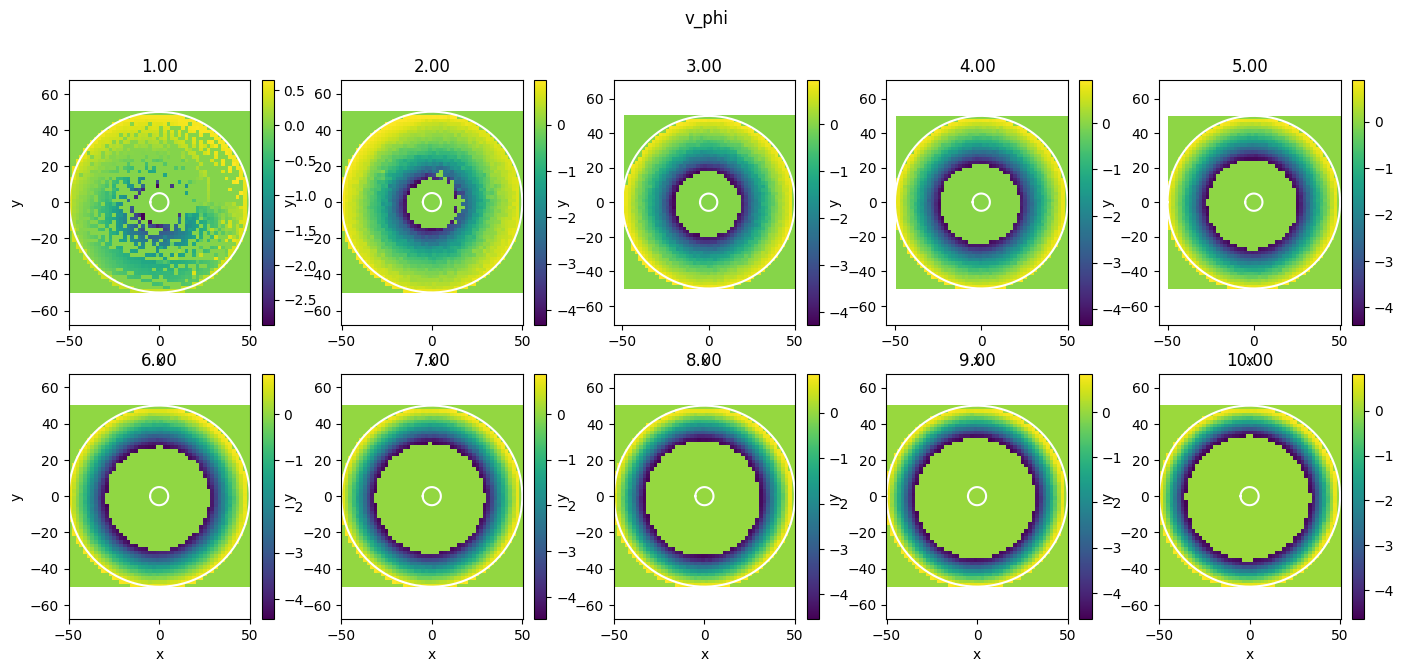

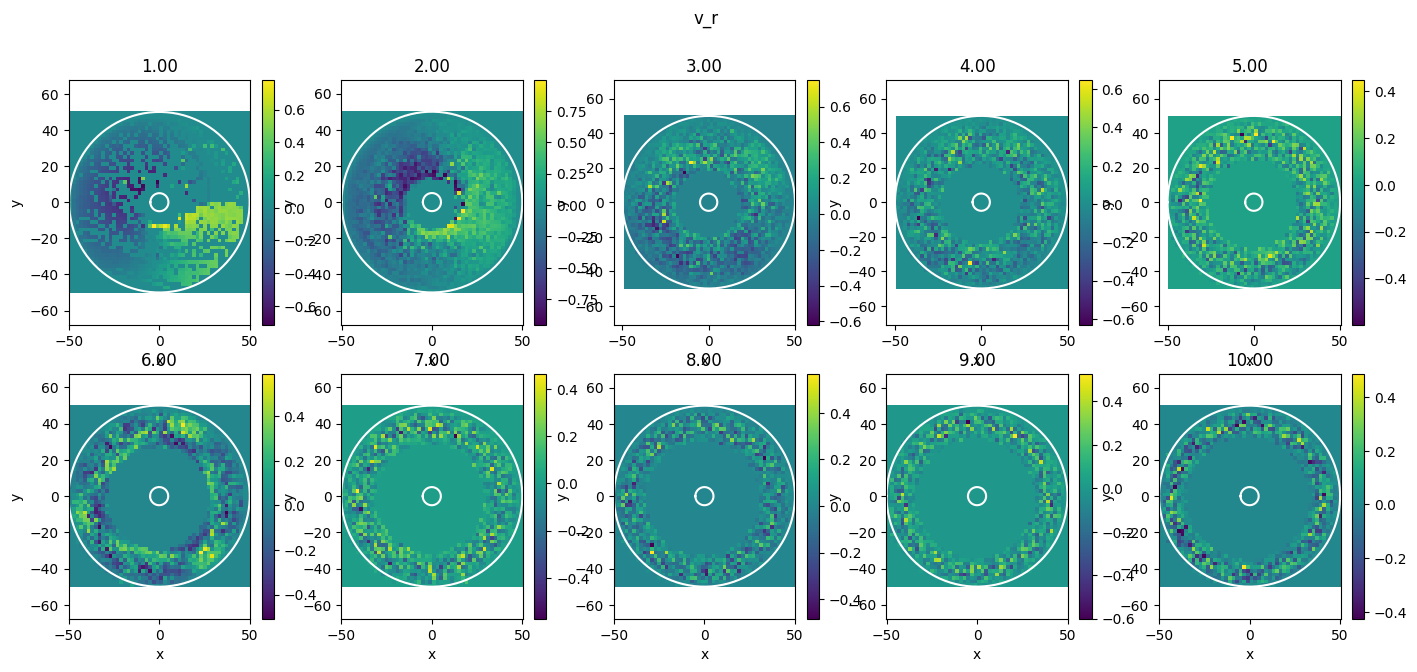

In [78]:
plot_velocity(R, Omegas1)

## With interaction

### $\varepsilon = 10$

In [94]:
ps, Rs, t = solver(1, 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 500000, noise = True)

Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


In [95]:
save_output(t, Rs, ps, N, 0.5, custom_name = "epsilon10_Omega1", skip = 100, num = 500000)

In [96]:
ps, Rs, t = solver(5, 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)

Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806


In [97]:
save_output(t, Rs, ps, N, 0.5, custom_name = "epsilon10_Omega5")

In [98]:
R.clear()
p.clear()
for i in range(len(Omegas)):
    print(i)
    ps, Rs, t = solver(Omegas[i], 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

0
No tumbling
omega/D_R: 0.0
1
No tumbling
omega/D_R: 34.066837495619566
2
No tumbling
omega/D_R: 68.13367499123913
3
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
4
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
5
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
6
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
7
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
8
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
9
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


In [99]:
save_output(t, R[-1], p[-1], N, Omegas[-1], custom_name = "epsilon10_Omega1")

No tumbling
omega/D_R: 0.0
No tumbling
omega/D_R: 34.066837495619566
No tumbling
omega/D_R: 68.13367499123913
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


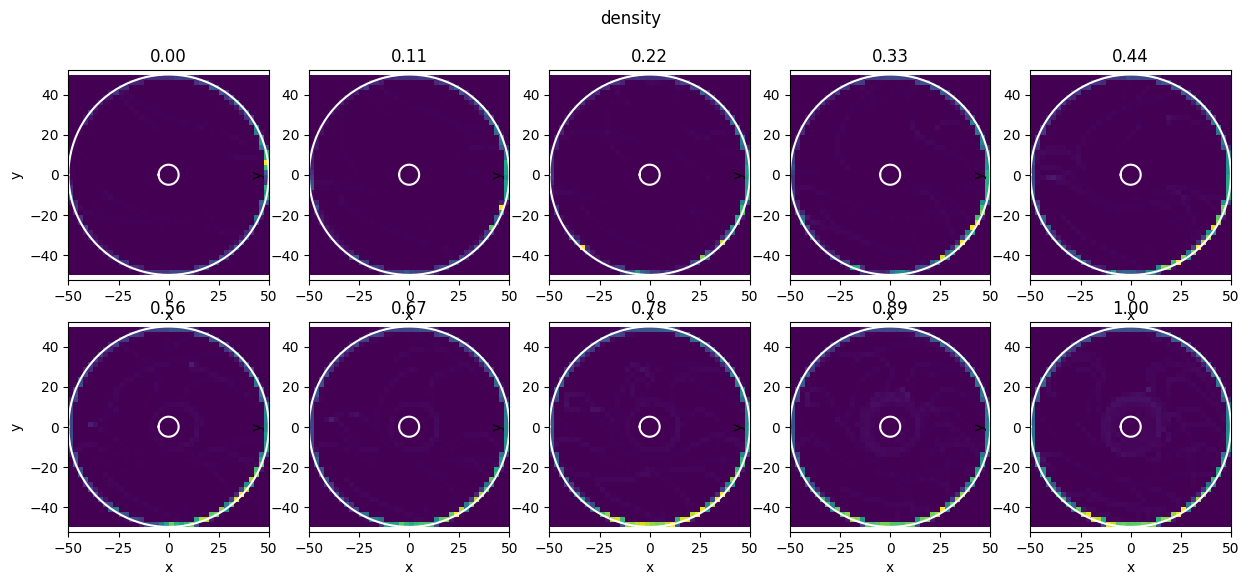

In [100]:
plot_density(R, Omegas)

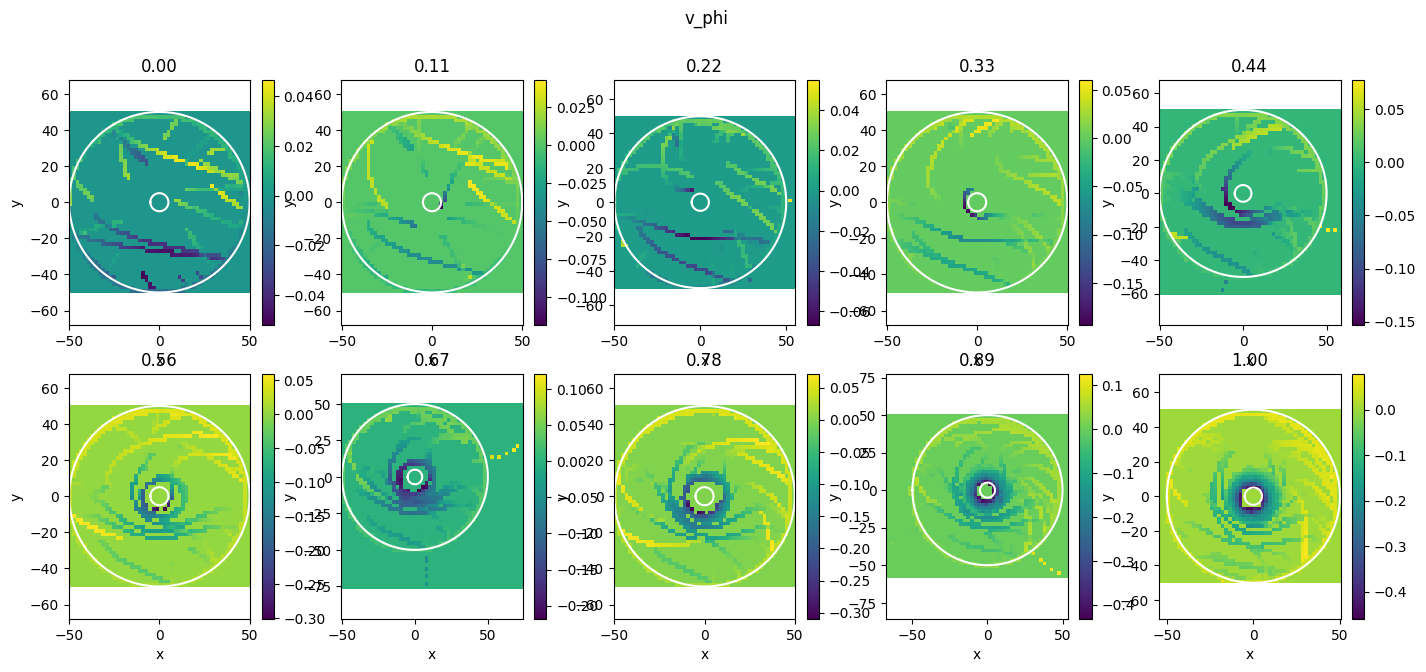

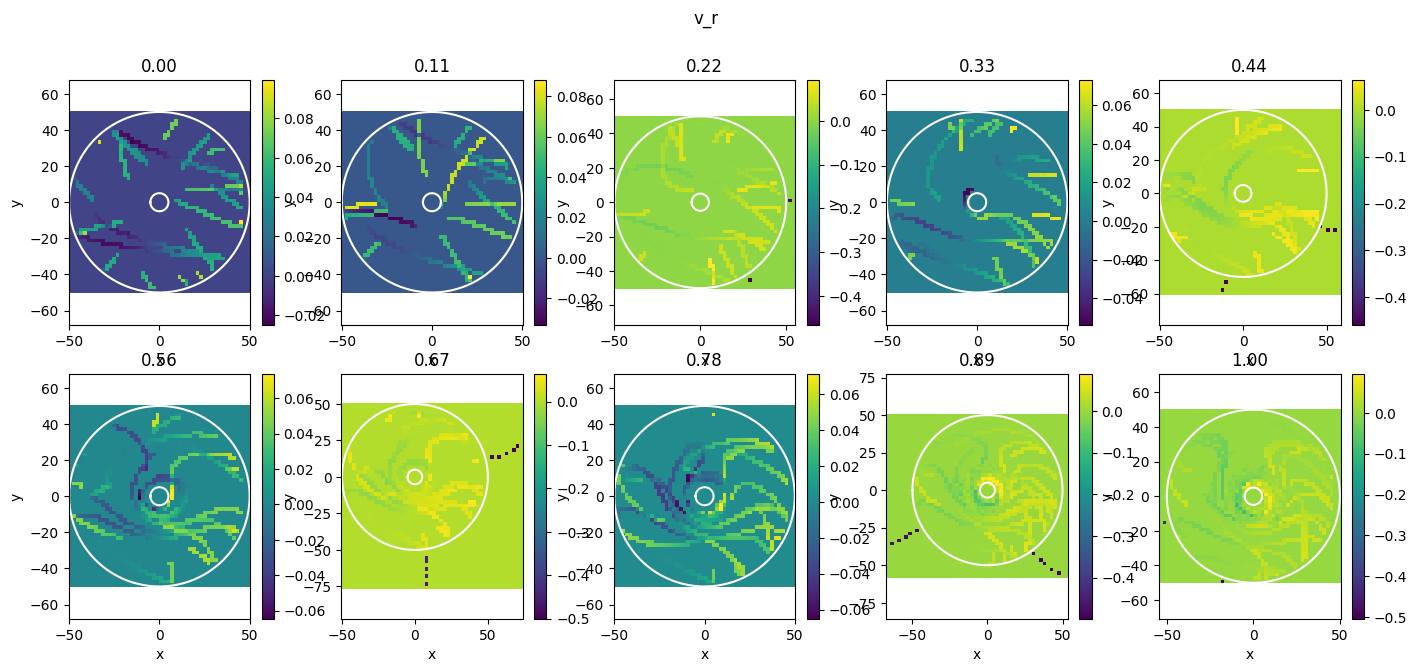

In [101]:
plot_velocity(R, Omegas)

In [102]:
R.clear()
p.clear()
for i in range(len(Omegas1)):
    print(i)
    ps, Rs, t = solver(Omegas1[i], 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

NameError: name 'Omegas1' is not defined

In [ ]:
plot_density(R, Omegas1)

In [ ]:
plot_velocity(R, Omegas1)

### Scan for epsilon

In [109]:
R.clear()
p.clear()
epsilons = np.linspace(1., 50., 10)
for i in range(len(epsilons)):
    print(i)
    ps, Rs, t = solver(3, epsilons[i], k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)
    R.append(Rs)
    p.append(ps)
    

0
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
1
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
4
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
5
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
6
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
7
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
8
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
9
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284


In [125]:
save_output(t, R[-1], p[-1], N, 5, custom_name="epsilon50", skip = 100, num = 100000)

In [133]:
nums = []
max_sizes = []
for j in range(len(epsilons)):
    clust_num = 0
    clust_size = 0
    for i in range(0, 100, 10):
        clust = np.sort(fclusterdata(R[j][ -1 - i, :, :], t=3, criterion='distance'))
        clust_num += clust[-1]
        clust_size += max_repetitions(clust) 
    clust_num = clust_num // len(epsilons)
    clust_size = clust_size // len(epsilons)
    nums.append(clust_num)
    max_sizes.append(clust_size)
nums

[np.int32(100),
 np.int32(95),
 np.int32(64),
 np.int32(57),
 np.int32(47),
 np.int32(48),
 np.int32(45),
 np.int32(45),
 np.int32(46),
 np.int32(42)]

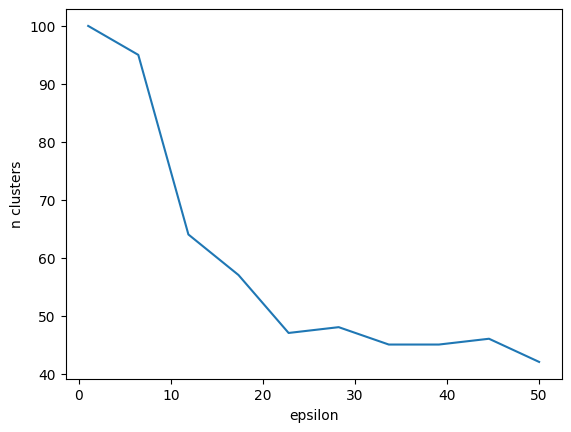

In [124]:
plt.plot(epsilons, nums)
plt.xlabel("epsilon")
plt.ylabel("n clusters")
plt.show()

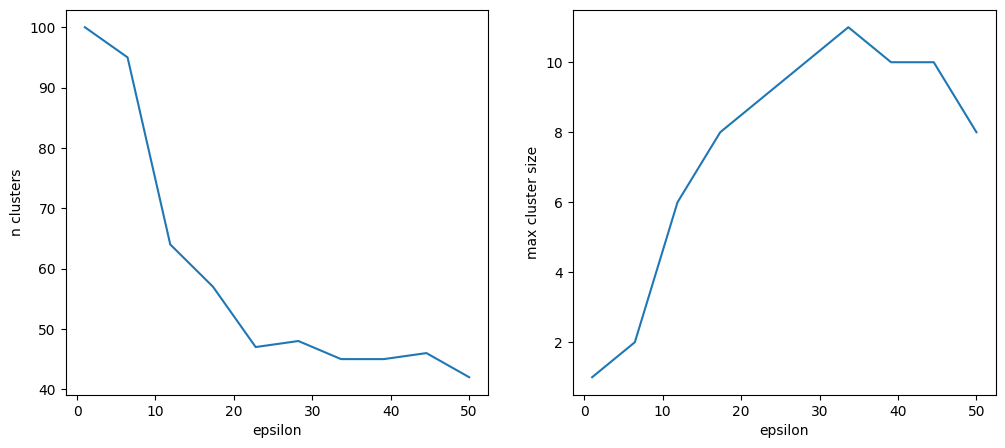

In [134]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))
axs[0].plot(epsilons, nums)
axs[1].plot(epsilons, max_sizes)
axs[0].set_xlabel('epsilon')
axs[0].set_ylabel('n clusters')
axs[1].set_xlabel('epsilon')
axs[1].set_ylabel('max cluster size')

plt.show()

In [136]:
R.clear()
p.clear()
nums.clear()
max_sizes.clear()
epsilons = np.linspace(1., 100., 20)
for j in range(len(epsilons)):
    print(j)
    ps, Rs, t = solver(3, epsilons[j], k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)
    clust_num = 0
    clust_size = 0
    for i in range(0, 100, 10):
        clust = np.sort(fclusterdata(Rs[ -1 - i, :, :], t=3, criterion='distance'))
        clust_num += clust[-1]
        clust_size += max_repetitions(clust) 
    clust_num = clust_num // len(epsilons)
    clust_size = clust_size // len(epsilons)
    nums.append(clust_num)
    max_sizes.append(clust_size)

0
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
1
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
4
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
5
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
6
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
7
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
8
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
9
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
10
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
11
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
12
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
13
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
14
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
15
Tu

In [138]:
save_output(t, Rs, ps, N, 5, custom_name="epsilon100", skip = 100, num = 100000)

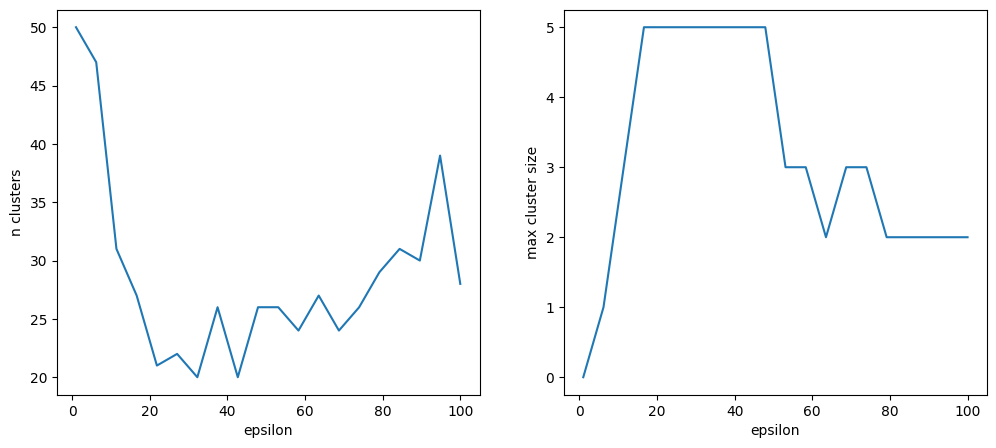

In [137]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))
axs[0].plot(epsilons, nums)
axs[1].plot(epsilons, max_sizes)
axs[0].set_xlabel('epsilon')
axs[0].set_ylabel('n clusters')
axs[1].set_xlabel('epsilon')
axs[1].set_ylabel('max cluster size')

plt.show()